# Marginal effects from metrics of extreme heat
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.ed

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from scipy import stats

Data locations

In [2]:
loc_panel = "../Data/Panel/"
loc_regression = "../Data/RegressionResults/"
loc_shp = "../Data/Shapefile/"

#### Analysis

Read panel to get scalings etc

In [3]:
edd_type = "month"
panel = pd.read_csv(loc_panel+"extremes_growth_panel_"+edd_type+"edd_1979-2016.csv",index_col=0)

In [4]:
panel_mean = panel.groupby("region").mean().reset_index().loc[:,["region","t"]]

Plot! Loop through metrics

In [5]:
metrics = ["txx","tx3d","tx5d","tx7d","tx15d","tmonx"]
ts = np.arange(-5,35+1,1)

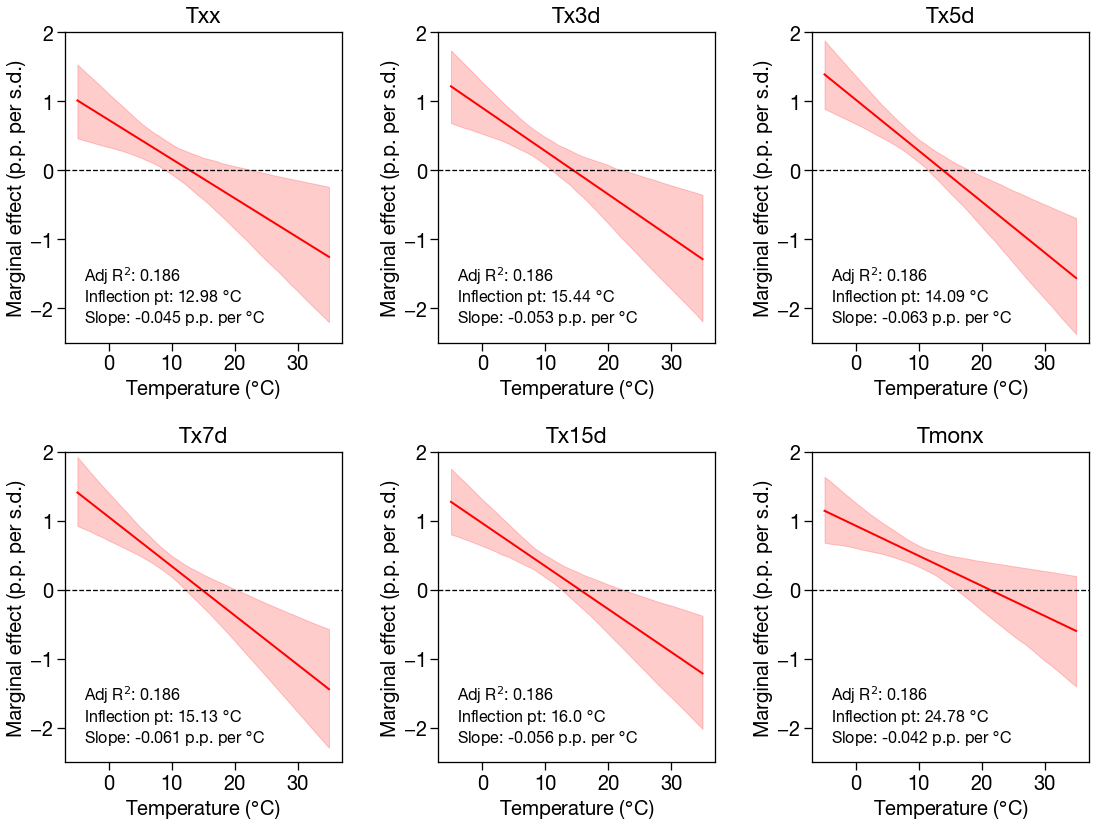

In [6]:
fig = plt.figure(figsize=(18,13))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.13,right=0.92,top=0.9,bottom=0.12,wspace=0.35,hspace=0.35)

for k in np.arange(0,len(metrics),1):
    ax = plt.subplot(gs1[k])
    metric = metrics[k]
    coefs_in = pd.read_csv(loc_regression+metric+"_coefs_bootstrap_contemporaneous.csv",index_col=0)
    slope = 100*np.nanmean(coefs_in.coef_interact.values)
    scaling = 100*np.nanmean(panel.groupby("region").std()[metrics[k]].values)
    #print(scaling)
    #print(np.nanmean(coefs_in.coef_main.values))
    boot = np.arange(0,len(coefs_in.boot.values))
    nboot = len(boot)
    me = np.zeros((nboot,len(ts)))
    for n in np.arange(0,nboot,1):
        me[n,:] = scaling*(coefs_in.coef_main.values[n] + coefs_in.coef_interact.values[n]*ts)
    me_mean = np.mean(me,axis=0)
    me_lower = np.percentile(me,2.5,axis=0)
    me_upper = np.percentile(me,97.5,axis=0)
    
    plt.plot(ts,me_mean,color="red",linewidth=2)
    ax.fill_between(ts,me_lower,me_upper,
                   color="red",alpha=0.2)
    plt.axhline(y=0,color="black",linestyle="--",linewidth=1.3)
    plt.xlabel("Temperature ($\degree$C)")
    plt.ylabel("Marginal effect (p.p. per s.d.)")
    plt.title("T"+metric[1:],pad=10,fontsize=22)
    plt.xlim([-7,37])
    plt.xticks([0,10,20,30])
    plt.ylim([-2.5,2])
    
    #inflection = ts[me_mean<0][0]
    inflections = np.zeros(nboot)
    for n in np.arange(0,nboot,1):
        inflections[n] = -1*coefs_in.coef_main.values[n]/coefs_in.coef_interact.values[n]
    inflection = np.around(np.mean(inflections),2)
    adj_r2 = np.around(np.nanmean(coefs_in.adj_r2.values),3)
    #print(inflection)
    plt.text(-4,-2.2,"Slope: "+str(np.around(slope,3))+" p.p. per $\degree$C",
             fontsize=16)
    plt.text(-4,-1.9,"Inflection pt: "+str(inflection)+" $\degree$C",
            fontsize=16)
    plt.text(-4,-1.6,"Adj R$^2$: "+str(adj_r2),
            fontsize=16)
    
plt.savefig("../Figures/Tx_Marginal_Effects.pdf")
plt.show()

Make maps

First read in shapefile

In [8]:
shp = gp.read_file(loc_shp+"gadm36_1.shp")
shp = shp.rename(columns={"GID_1":"region"})

Now calculate marginal effect for each region

In [9]:
me_data = panel.groupby("region").mean().reset_index().loc[:,["region","t"]]
me_data = me_data.loc[me_data.t!=0,:] # if its exactly zero, that indicates an error
extr = "tx5d"
coefs = pd.read_csv(loc_regression+extr+"_coefs_bootstrap_contemporaneous.csv",index_col=0)
scaling = 100*np.nanmean(panel.groupby("region").std()[extr].values)
coef_main_mean = np.nanmean(coefs.coef_main.values)
coef_intr_mean = np.nanmean(coefs.coef_interact.values)
me_data["ame_std"] = np.zeros(len(me_data.t.values))
for i in me_data.index.values:
    t_i = me_data.loc[me_data.index==i,"t"].values[0]
    me_data.loc[me_data.index==i,"ame_std"] = scaling*(coef_main_mean + coef_intr_mean*t_i)
shp_plot = pd.merge(shp,me_data,on="region",how="left")

Now map

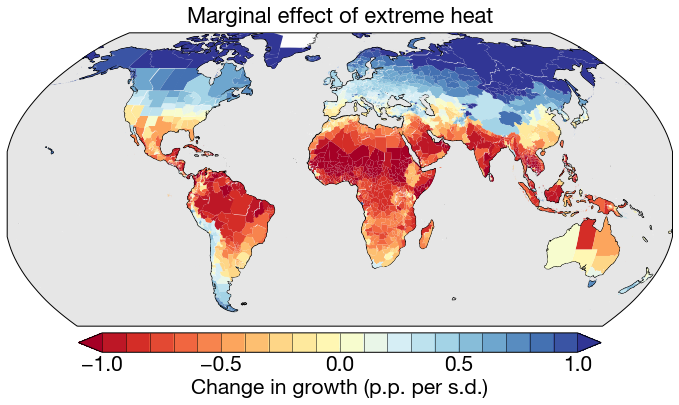

In [10]:
fig = plt.figure(figsize=(11,10))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 21.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 4
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 4
rcParams['ytick.major.width'] = 1

gs2 = gridspec.GridSpec(1,1)
gs2.update(left=0.12,right=0.96,top=0.9,bottom=0.2,wspace=0.02,hspace=0.3)

## now map

ax = plt.subplot(gs2[0,0],projection=ccrs.Robinson())
ax.set_extent([-180,180,-63,80],crs=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.9,0.9,0.9])
ax.add_feature(cart.feature.LAND, edgecolor="black",facecolor=[0.98,0.98,0.98])

vmin = -1
vmax = 1
ncol = 21 # choose a number greater than
                  # the number of colors you actually want
bounds = np.linspace(vmin,vmax,ncol)
cmapname = 'RdYlBu'
cols = plt.get_cmap(cmapname)(np.linspace(0,1,len(bounds)+1))
cm = colors.ListedColormap(cols[1:-1])
cm.set_over(cols[-1])
cm.set_under(cols[0]) #set_under(cols[0])
norm = colors.Normalize(vmin=vmin,vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)
baseline_col = [0.99,0.99,0.99]

for i in shp_plot.region:
    geom = shp_plot.loc[shp_plot.region==i,"geometry"]
    val = shp_plot.loc[shp_plot.region==i,"ame_std"].values[0]
    col = cbar.to_rgba(val)
    if (~np.isnan(val)):
        ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=col,
                          edgecolor="black",
                          linewidth=0,zorder=10)
    else:
        ax.add_geometries(geom,ccrs.PlateCarree(),
                          facecolor=baseline_col,
                          edgecolor="black",linewidth=0)


# colorbar and title
tfs = 22
b = 0.31
w = 0.66
h = 0.027
l = 0.21
plt.title("Marginal effect of extreme heat",pad=10,
          fontsize=tfs)
cbar_ax = fig.add_axes([l,b,w,h])
# colorbar
cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                      drawedges=True,extend="both",
                 ticks=[-1,-0.5,0,0.5,1])
cbar_ax.tick_params(direction="in",width=0.05)
cb.set_label("Change in growth (p.p. per s.d.)")

plt.savefig("../Figures/Tx5d_Marginal_Effects_Map.png")
plt.show()

Now plot distributed lag model results

In [7]:
extr = "tx5d"
boot_type = "region"

Plot marginal effects from models with different lags

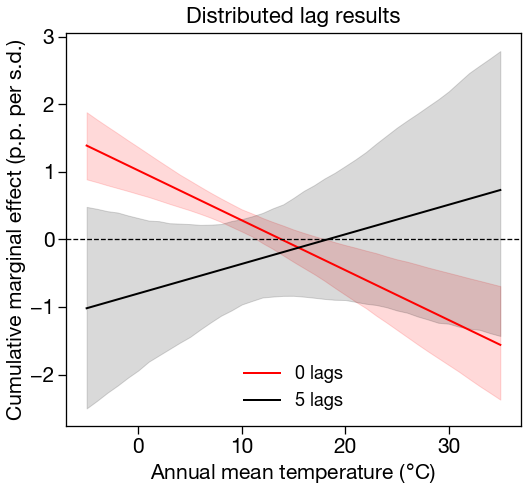

In [12]:
fig = plt.figure(figsize=(8,7))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 21.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.13,right=0.92,top=0.9,bottom=0.12,wspace=0.35,hspace=0.35)

ax = plt.subplot(gs1[0,0])

nlags = [0,5]
cols = ["red","black"]
ts = np.arange(-5,35+1,1)
scaling = 100*np.nanmean(panel.groupby("region").std()[extr].values)

for l in nlags:
    if l==0:
        all_coefs = pd.read_csv(loc_regression+extr+"_coefs_bootstrap_contemporaneous.csv",index_col=0)
        coefs_main = all_coefs.coef_main.values
        coefs_intr = all_coefs.coef_interact.values
    else:
        coefs_main_df = pd.read_csv(loc_regression+extr+"_coefs_bootstrap_"+boot_type+"_lag"+str(l)+".csv",index_col=0)
        coefs_intr_df = pd.read_csv(loc_regression+extr+"_coefs_interact_bootstrap_"+boot_type+"_lag"+str(l)+".csv",index_col=0)
        coefs_main = np.sum(coefs_main_df.iloc[:,1:].values,axis=1)
        coefs_intr = np.sum(coefs_intr_df.iloc[:,1:].values,axis=1)
        
    boot = np.arange(0,len(coefs_main),1)
    nboot = len(boot)
    me = np.zeros((nboot,len(ts)))
    for n in np.arange(0,nboot,1):
        me[n,:] = scaling*(coefs_main[n] + coefs_intr[n]*ts)
    me_mean = np.mean(me,axis=0)
    me_lower = np.percentile(me,2.5,axis=0)
    me_upper = np.percentile(me,97.5,axis=0)
    
    plt.plot(ts,me_mean,color=cols[nlags.index(l)],linewidth=2,
            label=str(l)+" lags")
    ax.fill_between(ts,me_lower,me_upper,
                   color=cols[nlags.index(l)],alpha=0.15)

plt.axhline(y=0,color="black",linewidth=1.3,linestyle="--")
plt.xlabel("Annual mean temperature ($\degree$C)")
plt.ylabel("Cumulative marginal effect (p.p. per s.d.)")
plt.legend(loc="lower center",frameon=False,fontsize=18)
plt.title("Distributed lag results",pad=10,fontsize=22)

plt.savefig("../Figures/FigX_Tx_DL_Effects_ByTemp.pdf")
plt.show()

AR models

In [13]:
extr = "tx5d"

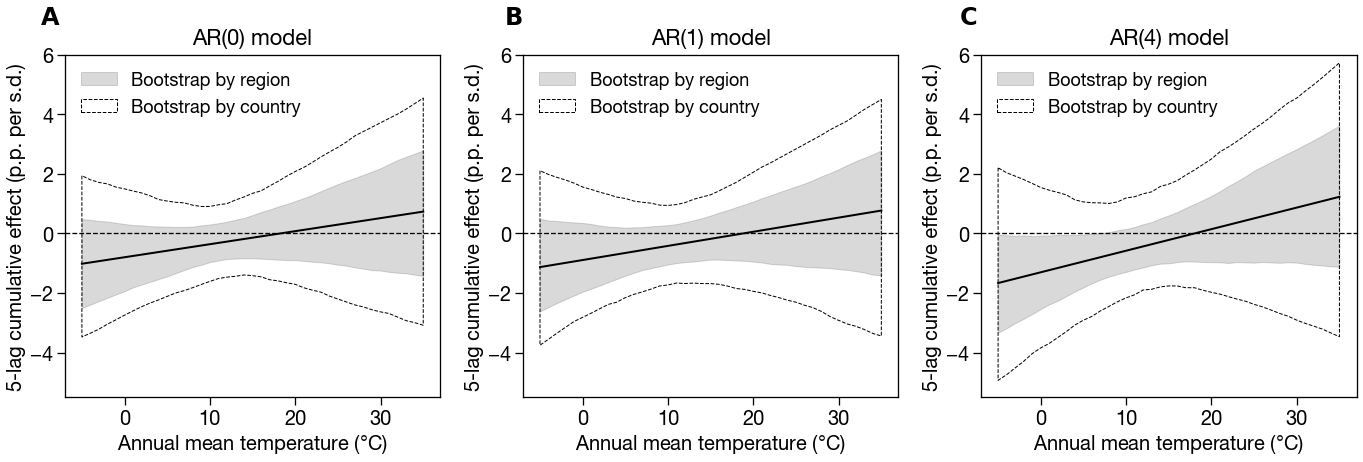

In [14]:
fig = plt.figure(figsize=(23,7))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.15,right=0.93,top=0.85,bottom=0.17,wspace=0.22,hspace=0.3)

ar_lengths = [0,1,4]
boot_types = ["region","country"]
#linestyle = ["--",".-"]
lags = [5,5,5]

for j in np.arange(0,len(ar_lengths),1):
    ax = plt.subplot(gs1[0,j])

    ts = np.arange(-5,35+1,1)
    scaling = 100*np.nanmean(panel.groupby("region").std()[extr].values)
    
    for b in np.arange(0,len(boot_types),1):
        if ar_lengths[j]==0:
            coefs_main_df = pd.read_csv(loc_regression+extr+"_coefs_bootstrap_"+boot_types[b]+"_lag"+str(lags[j])+".csv",index_col=0)
            coefs_intr_df = pd.read_csv(loc_regression+extr+"_coefs_interact_bootstrap_"+boot_types[b]+"_lag"+str(lags[j])+".csv",index_col=0)
            coefs_main = np.sum(coefs_main_df.iloc[:,1:].values,axis=1)
            coefs_intr = np.sum(coefs_intr_df.iloc[:,1:].values,axis=1)
        else:
            coefs_main_df = pd.read_csv(loc_regression+extr+"_coefs_bootstrap_"+boot_types[b]+"_lag"+str(lags[j])+"_ar"+str(ar_lengths[j])+".csv",index_col=0)
            coefs_intr_df = pd.read_csv(loc_regression+extr+"_coefs_interact_bootstrap_"+boot_types[b]+"_lag"+str(lags[j])+"_ar"+str(ar_lengths[j])+".csv",index_col=0)
            coefs_main = np.sum(coefs_main_df.iloc[:,1:].values,axis=1)
            coefs_intr = np.sum(coefs_intr_df.iloc[:,1:].values,axis=1)

        boot = np.arange(0,len(coefs_main),1)
        nboot = len(boot)
        me = np.zeros((nboot,len(ts)))
        for n in np.arange(0,nboot,1):
            me[n,:] = scaling*(coefs_main[n] + coefs_intr[n]*ts)
        me_mean = np.mean(me,axis=0)
        me_lower = np.percentile(me,2.5,axis=0)
        me_upper = np.percentile(me,97.5,axis=0)
    
        if b==0:
            plt.plot(ts,me_mean,color=cols[nlags.index(l)],linewidth=2)
            ax.fill_between(ts,me_lower,me_upper,
                        color=cols[nlags.index(l)],alpha=0.15,label="Bootstrap by "+boot_types[b])
        else:
            ax.fill_between(ts,me_lower,me_upper,linewidth=1,edgecolor="black",
                        facecolor="",alpha=1,label="Bootstrap by "+boot_types[b],
                           linestyle="--")

    plt.axhline(y=0,color="black",linewidth=1.3,linestyle="--")
    plt.xlabel("Annual mean temperature ($\degree$C)")
    plt.ylabel(str(lags[j])+"-lag cumulative effect (p.p. per s.d.)")
    plt.legend(loc="upper left",frameon=False,fontsize=18)
    plt.title("AR("+str(ar_lengths[j])+") model",pad=10,fontsize=22)
    plt.ylim([-5.5,6])
    
plt.figtext(0.135,0.91,r'$\bf{A}$',fontsize=24)
plt.figtext(0.415,0.91,r'$\bf{B}$',fontsize=24)
plt.figtext(0.69,0.91,r'$\bf{C}$',fontsize=24)

plt.savefig("../Figures/FigX_Tx_ARDL_Effects.pdf")
plt.show()

Extreme degree day effects

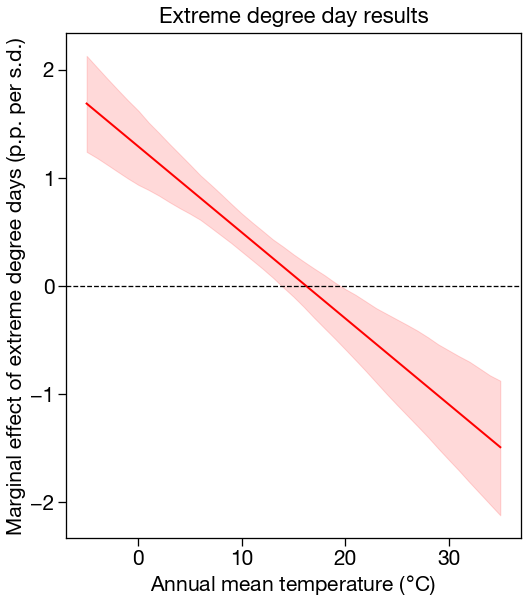

In [10]:
fig = plt.figure(figsize=(8,9))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 21.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.13,right=0.92,top=0.9,bottom=0.12,wspace=0.35,hspace=0.35)

ax = plt.subplot(gs1[0,0])

ts = np.arange(-5,35+1,1)
extr = "edd95"
scaling = 100*np.nanmean(panel.groupby("region").std()[extr].values)

all_coefs = pd.read_csv(loc_regression+extr+"_coefs_bootstrap_contemporaneous.csv",index_col=0)
coefs_main = all_coefs.coef_main.values
coefs_intr = all_coefs.coef_interact.values
        
boot = np.arange(0,len(coefs_main),1)
nboot = len(boot)
me = np.zeros((nboot,len(ts)))
for n in np.arange(0,nboot,1):
    me[n,:] = scaling*(coefs_main[n] + coefs_intr[n]*ts)
me_mean = np.mean(me,axis=0)
me_lower = np.percentile(me,2.5,axis=0)
me_upper = np.percentile(me,97.5,axis=0)
    
plt.plot(ts,me_mean,color="red",linewidth=2)
ax.fill_between(ts,me_lower,me_upper,color="red",alpha=0.15)

plt.axhline(y=0,color="black",linewidth=1.3,linestyle="--")
plt.xlabel("Annual mean temperature ($\degree$C)")
plt.ylabel("Marginal effect of extreme degree days (p.p. per s.d.)")
plt.title("Extreme degree day results",pad=10,fontsize=22)

plt.savefig("../Figures/FigX_EDD_Effects.pdf")
plt.show()

In [15]:
scaling*(np.mean(coefs_main) + (23.8*np.mean(coefs_intr)))

-0.6017099619174734